<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/generative_dl/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Style Transfer

This consists on generating a new image from a base one but with the style or texture of a second, tipically artistic.

This is achieved by optimizing a loss based on three components:
1. Style Loss.
1. Content Loss.
1. Total Variation Loss.


The **Total Variation Loss** ensures local spatial continuity between the combined image, meaning this a visual coherense.

More algebraic details in the future HAHA.

In [124]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = '/content/_DSC0061.JPG'
style_ref_image_path = keras.utils.get_file('picassob.jpg', 'https://i.pinimg.com/originals/44/97/60/449760694a99ef94adc933c690da6af4.jpg')

result_prefix = 'b_ernes_generated'

Weights of the different components

In [115]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

Dimensions of the generated picture

In [116]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

##Preview
Let's review the base content and the style reference

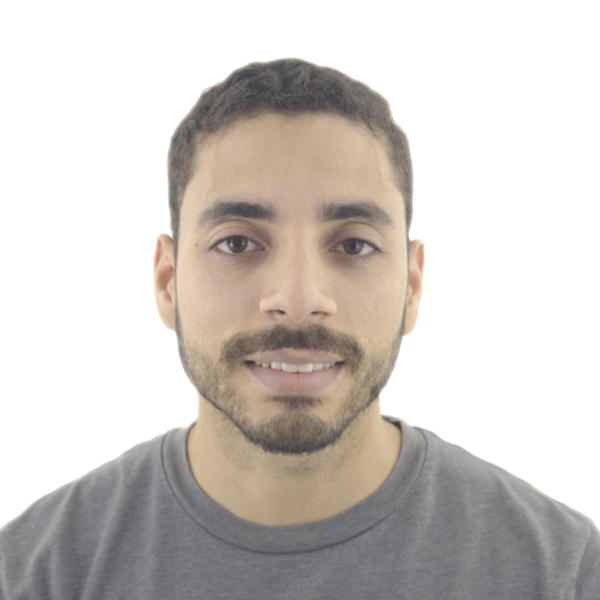

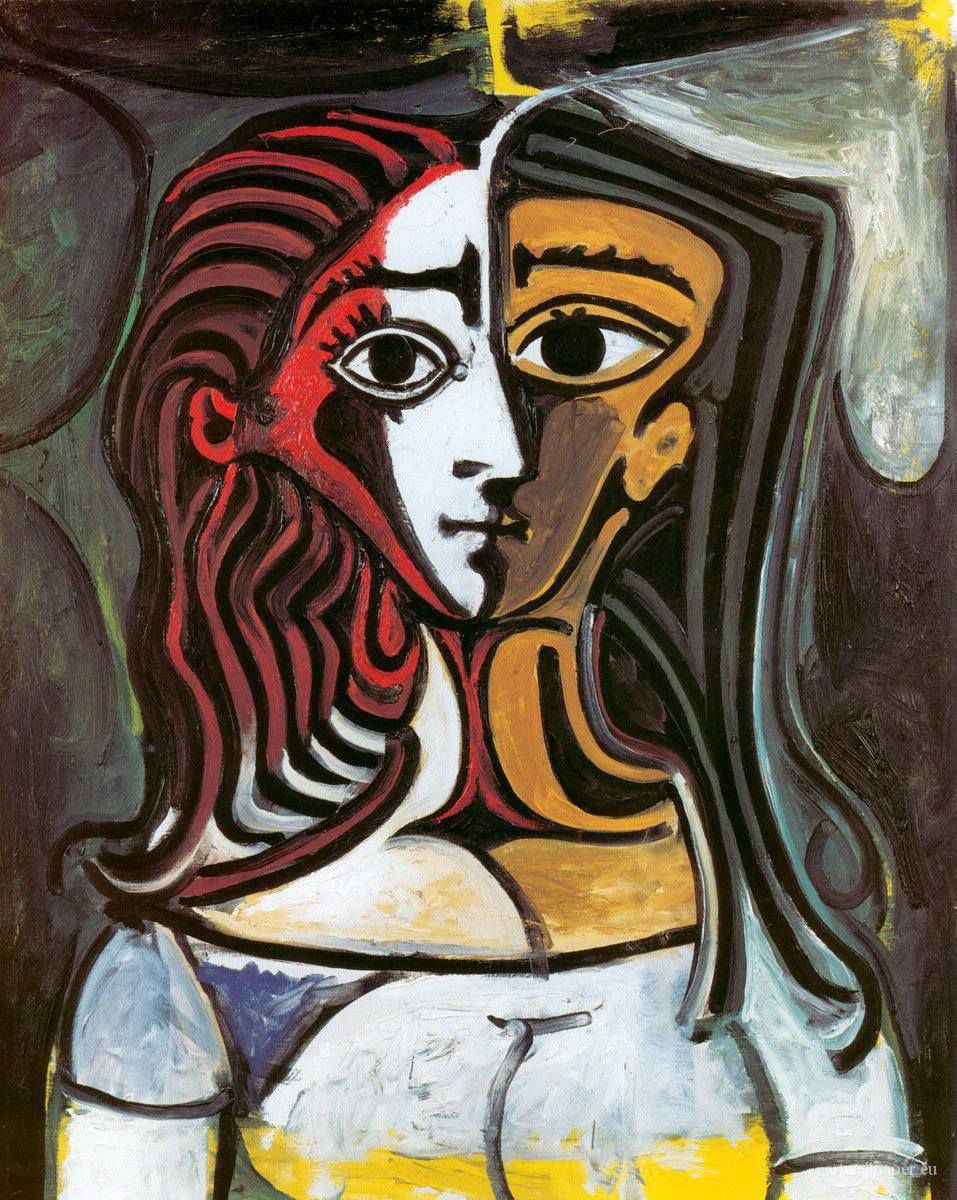

In [117]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_ref_image_path))

##Image Preprocessing and Deprocessing functions

In [118]:
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(
      image_path, target_size=(img_nrows, img_ncols)
  )
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)

  # return tf.convert_to_tensor(img)
  return img

def deprocess_image(x):
  x = x.reshape((img_nrows, img_ncols, 3))
  # Remove zero-cenver by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  # From 'BGR' to 'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')

  return x

##Compute the Style Transfer Loss

Here we have 4 components.

- `gram_matrix`: To compute Style Loss.
- the `style_loss` function: Keeps the generated image close to the local texture of the style reference image.
- the `content_loss` function: Keeps the high-level representation of the generated image close to that of the base image.
- the `total_variation_loss` function: A regularization loss which keeps the generated image locally-coherent.

In [119]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))

  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols

  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
  a = tf.square(
    x[:, :img_nrows - 1, :img_ncols - 1, :] -
    x[:, 1:, :img_ncols - 1, :])
  b = tf.square(
      x[:, :img_nrows - 1, :img_ncols - 1, :] -
      x[:, :img_nrows - 1, 1:, :])
  # a = tf.square(
  #     x[:, : img_nrows - 1, img_ncols -1, :] - x[:, 1:, : img_ncols -1, :]
  # )
  # b = tf.square(
  #     x[:, :img_nrows -1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :]
  # )

  return tf.reduce_sum(tf.pow(a + b, 1.25))

##Build the VGG19 model
This model with loaded the pre-trained ImageNet weights 

In [120]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
# Capture the symbolic output of each layer (key)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Now we set a model that returns the activation value for every 
# layer in the given model (VGG19) as a dict
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

###The Style Transfer `compute_loss` function

In [121]:
# Layers to use for the style loss

style_layers_names = [
  'block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1',
]
content_layer_name = 'block5_conv2'

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat(
      [base_image, style_reference_image, combination_image], axis=0
  )
  features = feature_extractor(input_tensor)

  loss = tf.zeros(shape=())
  # Content Loss
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  
  loss = loss + content_weight  * content_loss(base_image_features, combination_features)

  # Add style loss
  for layer_name in style_layers_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]

    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers_names)) * sl

  # Add total variation loss
  loss += total_variation_weight * total_variation_loss(combination_image)

  return loss

## Adds `tf.function` decorator to `loss` and `gradient computation`

In [122]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)

  return loss, grads

##Training Loop

Here we will run vanilla gradient descent to minimize the loss and save the image every 100th iteration.

In [125]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_ref_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4_000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])

  if i % 100 == 0:
    print('Iteration %d: loss=%.2f' % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + '_at_iteration%d.png' % i
    keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=5607.46
Iteration 200: loss=4432.17
Iteration 300: loss=3976.81
Iteration 400: loss=3721.66
Iteration 500: loss=3551.47
Iteration 600: loss=3427.55
Iteration 700: loss=3332.73
Iteration 800: loss=3256.89
Iteration 900: loss=3193.94
Iteration 1000: loss=3141.04
Iteration 1100: loss=3095.38
Iteration 1200: loss=3055.58
Iteration 1300: loss=3020.71
Iteration 1400: loss=2989.53
Iteration 1500: loss=2961.51
Iteration 1600: loss=2936.25
Iteration 1700: loss=2913.20
Iteration 1800: loss=2892.15
Iteration 1900: loss=2872.87
Iteration 2000: loss=2855.16
Iteration 2100: loss=2838.74
Iteration 2200: loss=2823.44
Iteration 2300: loss=2809.24
Iteration 2400: loss=2796.07
Iteration 2500: loss=2783.73
Iteration 2600: loss=2772.15
Iteration 2700: loss=2761.34
Iteration 2800: loss=2751.25
Iteration 2900: loss=2741.77
Iteration 3000: loss=2732.87
Iteration 3100: loss=2724.49
Iteration 3200: loss=2716.61
Iteration 3300: loss=2709.21
Iteration 3400: loss=2702.20
Iteration 3500: loss=26

###Final Result

In [ ]:
display(Image(f"/content/{result_prefix}_at_iteration4000.png"))